In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, CSVLogger

In [8]:
os.chdir('/content/drive/My Drive/GitHub Repositories/State of Art Segmentation Network Architectures')
dataDir = ('./datasets/TOP-VIEW HEADS DATASET')

images = np.load(os.path.join(dataDir, 'images(8 Bit).npy'))

# Z-score Normalization
mean = np.mean(images)
std = np.std(images)
images -= mean
images /= std


masks = np.load(os.path.join(dataDir, 'masks.npy'))
# Normalize masks to [0, 1]
masks /= 255. 

print('Images: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(images.shape, images.dtype, np.amax(images), np.amin(images)))
print('Masks: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(masks.shape, masks.dtype, np.amax(masks), np.amin(masks)))

images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=2020)
print('Train Images: {} | Train Masks: {}'.format(images_train.shape, masks_train.shape))
print('Validation Images: {} | Validation Masks: {}'.format(images_test.shape, masks_test.shape))

Images: (1815, 96, 128, 1) | Dtype: float32 | Max-Val: 0.5567962527275085 | Min-Val: -3.5179946422576904
Masks: (1815, 96, 128, 1) | Dtype: float32 | Max-Val: 1.0 | Min-Val: 0.0
Train Images: (1452, 96, 128, 1) | Train Masks: (1452, 96, 128, 1)
Validation Images: (363, 96, 128, 1) | Validation Masks: (363, 96, 128, 1)


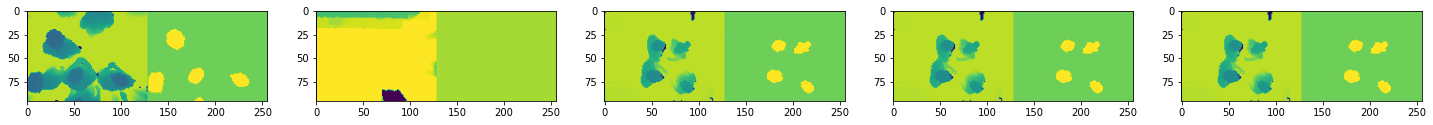

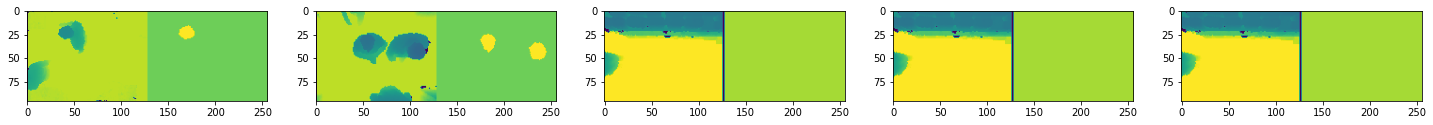

In [9]:
import matplotlib.pyplot as plt

def plotMask(images, masks):
    sample = []
    for i in range(10):
        left = images[i, :, :, 0]
        right = masks[i, :, :, 0]
        combined = np.hstack((left,right))
        sample.append(combined)
        
    for i in range(0, 10, 5):
        plt.figure(figsize=(25,10))
        
        plt.subplot(2, 5, 1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2, 5, 2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2, 5, 3+i)
        plt.imshow(sample[i+2])

        plt.subplot(2, 5, 4+i)
        plt.imshow(sample[i+2])

        plt.subplot(2, 5, 5+i)
        plt.imshow(sample[i+2])
        
        plt.show()

plotMask(images_test, masks_test)

In [10]:
img_rows = 96
img_cols = 128
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
        how many relevant items are selected. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
        how many selected items are relevant. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1score =  2 * ((precision * recall) / (precision + recall))
    return f1score

def SegNet_Architecture():
  inputs = Input((img_rows, img_cols, 1))
  # Encoder 
  outputs = Conv2D(32, (3, 3), padding='same') (inputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = Conv2D(32, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = MaxPooling2D()(outputs)

  outputs = Conv2D(64, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = Conv2D(64, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = MaxPooling2D()(outputs)

  outputs = Conv2D(128, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)  
  outputs = Conv2D(128, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = Conv2D(128, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = MaxPooling2D()(outputs)

  outputs = Conv2D(256, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)  
  outputs = Conv2D(256, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = Conv2D(256, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = MaxPooling2D()(outputs)

  outputs = Conv2D(256, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)  
  outputs = Conv2D(256, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = Conv2D(256, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = MaxPooling2D()(outputs)


  outputs = UpSampling2D(size=(2, 2))(outputs)
  outputs = Conv2D(256, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = Conv2D(256, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = Conv2D(256, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)

  outputs = UpSampling2D(size=(2, 2))(outputs)
  outputs = Conv2D(256, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = Conv2D(256, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = Conv2D(256, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)

  outputs = UpSampling2D(size=(2, 2))(outputs)
  outputs = Conv2D(128, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = Conv2D(128, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = Conv2D(64, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)

  outputs = UpSampling2D(size=(2, 2))(outputs)
  outputs = Conv2D(64, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs = Conv2D(32, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)

  outputs = UpSampling2D(size=(2, 2))(outputs)
  outputs = Conv2D(32, (3, 3), padding='same')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('relu')(outputs)
  outputs= Conv2D(1, (1, 1), padding='valid')(outputs)
  outputs = BatchNormalization(axis=3)(outputs)
  outputs = Activation('sigmoid')(outputs)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

model = SegNet_Architecture()
model.compile(loss=dice_coef_loss, optimizer=Adam(lr=1e-3), metrics=[dice_coef, 'accuracy', precision, recall, f1score])
model.summary()















Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 128, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 128, 32)       320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 128, 32)       128       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 128, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 128, 32)       9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 128, 32)       128       
_________________________________________________________________
activation_2 (Activation)    (None, 96, 128, 

In [11]:
modelDir = './saved Models/SegNet Models/TOP VIEW HEADS'
if not os.path.exists(modelDir):
  os.makedirs(modelDir)
  print('Directory Created')
  
csv_logger = CSVLogger('./saved Models/SegNet Models/TOP VIEW HEADS/Training-Logs.csv')
checkpoint = ModelCheckpoint('./saved Models/SegNet Models/TOP VIEW HEADS/best-model.h5', verbose=1, monitor='val_acc',
                             save_best_only=True, mode='auto')  

model.fit(images_train, masks_train, batch_size=64, epochs=100, verbose=1, shuffle=True, validation_data = (images_test, masks_test),
          callbacks=[csv_logger, checkpoint])



Train on 1452 samples, validate on 363 samples
Epoch 1/100
1452/1452 [==============================] - 17s 12ms/step - loss: -0.1196 - dice_coef: 0.1196 - acc: 0.7301 - precision: 0.1204 - recall: 0.8753 - f1score: 0.2110 - val_loss: -0.0987 - val_dice_coef: 0.0987 - val_acc: 0.3701 - val_precision: 0.0561 - val_recall: 0.9086 - val_f1score: 0.1057

Epoch 00001: val_acc improved from -inf to 0.37013, saving model to ./saved Models/SegNet Models/TOP VIEW HEADS/best-model.h5
Epoch 2/100
1452/1452 [==============================] - 3s 2ms/step - loss: -0.1429 - dice_coef: 0.1429 - acc: 0.8353 - precision: 0.1941 - recall: 0.9808 - f1score: 0.3232 - val_loss: -0.1593 - val_dice_coef: 0.1593 - val_acc: 0.8407 - val_precision: 0.1784 - val_recall: 0.8022 - val_f1score: 0.2917

Epoch 00002: val_acc improved from 0.37013 to 0.84065, saving model to ./saved Models/SegNet Models/TOP VIEW HEADS/best-model.h5
Epoch 3/100
1452/1452 [==============================] - 3s 2ms/step - loss: -0.1519 -

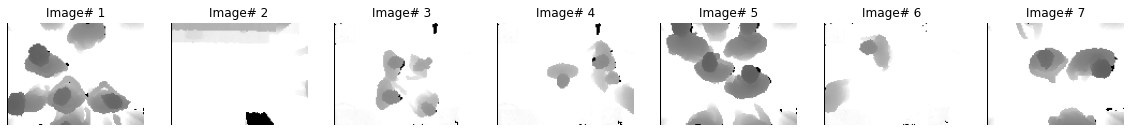

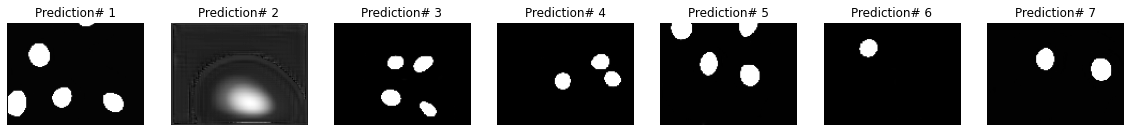

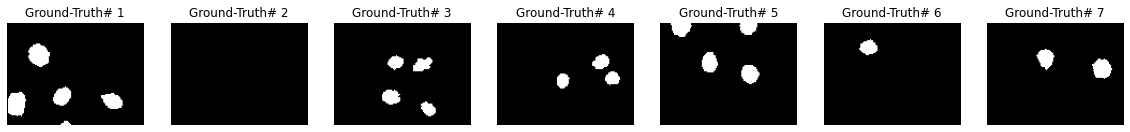

In [15]:
def plot_images(images_test, pred, masks_test):
  plt.figure(1, figsize = (20, 20))
  for i in range(7):
    plt.subplot(1, 7, i+1).set_title('Image# {}' .format(i+1))
    plt.imshow(images_test[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.figure(2, figsize = (20, 20))
  for i in range(7):
    plt.subplot(1, 7, i+1).set_title('Prediction# {}' .format(i+1))
    plt.imshow(pred[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.figure(3, figsize = (20, 20))
  for i in range(7):
    plt.subplot(1, 7, i+1).set_title('Ground-Truth# {}' .format(i+1))
    plt.imshow(masks_test[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.show()
  plt.close()

pred = model.predict(images_test)
plot_images(images_test, pred, masks_test)